In [1]:
import numpy as np
import scipy as sp
import scipy.interpolate as interp
import sys,json,os
sys.path.append('../..')
import matplotlib.pyplot as plt
import Project.profiles as pp
import Project.new_profiles as pnp
import Project.plot_assist as pa
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

In [2]:
dmo = json.load(open('../../sim_RC_12/Output/resdicts/dmo_sim_dict.json','r'))
for gal in dmo:
    dmo[gal]['core_fit'] = dmo[gal]['sidm_fit']
    dmo[gal]['cusp_fit'] = dmo[gal]['nfw_fit']
bry = json.load(open('../../sim_RC_12/Output/resdicts/Bry_2sig_dict.json','r'))
bry_1 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_1sig_dict.json','r'))
bry_p5 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_p5sig_dict.json','r'))
sparcd = json.load(open('../../obs_RC_v4/Output/result_dicts/sparc_fit_dict.json','r'))

In [3]:
LM = np.zeros([15,15])
RN = np.zeros([15,15])
for lm_i in range(15):
    for rn_i in range(15):
        LM[lm_i,rn_i] = lm_i
        RN[lm_i,rn_i] = 14-rn_i
masses = np.array([9.0,9.3,9.6,9.9,10.2,10.5,10.8,11.1,11.4,11.7,12.0,12.3,12.6,12.9,13.2,13.5])
radius = np.array([0.2,0.4,0.6,0.8,1.0,1.4,1.8,2.2,2.6,3.0,3.4,3.8,4.2,4.6,5.0,5.4])
mass = 0.5*(masses[:-1]+masses[1:])
rad = 0.5*(radius[:-1]+radius[1:])
new_radius = [radius[-i-1] for i in range(len(radius))]
data = [[(1.,1.,1.) for i in range(16)] for i in range(16)]

In [4]:
lsig_edges = np.array([-2,-1,-0.5,0,0.5,1,1.5,2.,2.25,2.5,2.75,3.,3.5,4.,4.5,5])
lsigs = 0.5*(lsig_edges[:-1]+lsig_edges[1:])
LS = [[lsigs[i] for j in range(15)] for i in range(15)]
LS = np.array(LS)

In [5]:
LM_xi = sp.interpolate.interp1d(mass,np.arange(0,15,1),fill_value = (0,14),bounds_error = False)
RN_yi = sp.interpolate.interp1d(rad,np.arange(14,-1,-1),fill_value = (14,0),bounds_error = False)
LS_xi = sp.interpolate.interp1d(lsigs,np.arange(0,15,1),fill_value = (0,14),bounds_error = False)
LS_yi = sp.interpolate.interp1d(lsigs,np.arange(14,-1,-1),fill_value = (14,0),bounds_error = False)

In [6]:
def get_axes(wspace = 0.2,xkey = ['lm','lm'], ykey = ['rn','rn'], title = True):
    fig,axs = plt.subplots(1,2, figsize = (10,5),gridspec_kw = {'wspace':wspace})
    for i in range(2):
        ax = axs[i]
        ax.imshow(data, alpha = 0.)
        ax.set_xticks(np.arange(-0.5,15.5,1))
        if xkey[i] == 'ls':
            ax.set_xticklabels(lsig_edges,rotation = 45)
        else:
            ax.set_xticklabels(masses,rotation = 45)
        ax.set_yticks(np.arange(-0.5,15.5,1))
        if ykey[i] == 'ls':
            ax.set_yticklabels([lsig_edges[-i - 1] for i in range(len(lsig_edges))])
        else:
            ax.set_yticklabels(new_radius)
        ax.tick_params(axis = 'both',direction = 'in',right = True,top = True, width = 1,length = 4)
        ax.grid(ls = '-',color = 'grey',alpha = 0.2)
        if xkey[i] == 'ls':
            ax.set_xlabel('log($\Sigma_0\,/\,\mathrm{M_{\odot}\,pc^{-2}}$)',size = 13,labelpad = 0)
        else:
            ax.set_xlabel('log($\mathrm{M_{200}/M_{\odot}}$)',size = 13,labelpad = 0)
        if ykey[i] == 'ls':
            ax.set_ylabel('log($\Sigma_0\,/\,\mathrm{M_{\odot}\,pc^{-2}}$)',size = 13,labelpad = 0)
        else:
            ax.set_ylabel('$r_{\:\mathrm{last}}\:/\:r_s$',size = 15,labelpad = 0)
        ax.set_ylim(14.5,-0.5)
        ax.set_xlim(-0.5,14.5)
        if title:
            axs[0].set_title('Input: CUSP', color = pa.green)
            axs[1].set_title('Input: CORE', color = pa.purple)
    return fig,axs[0],axs[1]
Clr = lambda clr,l,r = 0.2: [clr[r*(+1)] for i in range(l)]

In [7]:
def Zsmooth(oriX,oriY,oriZ,dN):
    X,Y,Z = oriX.copy(),oriY.copy(),oriZ.copy()
    X2,Y2,Z2 = X[::dN,::dN],Y[::dN,::dN],Z[::dN,::dN]
    Z_smooth =  interp.griddata(np.array([X2.ravel(),Y2.ravel()]).T,Z2.ravel(),(X,Y),method='cubic')
    return Z_smooth
def Delsmall(cn,diametercutoff = 4):
    for level in cn.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            verts = path.vertices
            diameter = np.max(verts.max(axis = 0) - verts.min(axis = 0))

            if diameter < diametercutoff:
                del(level.get_paths()[kp])
    return cn

In [684]:
prior = 'lcdm_vmax_shm'
lmi_sparc,lsi_sparc,rni_sparc = [],[],[]
lmip_sparc,lsip_sparc,rnip_sparc = [],[],[]
lmim_sparc,lsim_sparc,rnim_sparc = [],[],[]
lbf_sparc = []
for gal in sparcd[prior]:
    bestfit = sparcd[prior][gal]['best_fit']
    gald = sparcd[prior][gal][bestfit]
    lm = gald['lm']
    lmstar = gald['lmstar']
    rdstar = gald['rdstar']
    rn = sparcd[prior][gal]['rlast']/gald['rs'][0]
    rnp = sparcd[prior][gal]['rlast']/(gald['rs'][0]-gald['rs'][1])
    rnm = sparcd[prior][gal]['rlast']/(gald['rs'][0]+gald['rs'][1])
    if rnp < rn:
        rnp = rn
    if rnm > rn:
        rnm = rn
    ls = np.log10(pp.sig_exp(lmstar[0],rdstar[0])) - 6
    lsp = np.log10(pp.sig_exp(lmstar[0]+lmstar[1],rdstar[0]-rdstar[1])) - 6
    lsm = np.log10(pp.sig_exp(lmstar[0]-lmstar[1],rdstar[0]+rdstar[1])) - 6
    lmi_sparc.append(LM_xi(lm[0]))
    lsi_sparc.append(LS_xi(ls))
    rni_sparc.append(RN_yi(rn))
    lmip_sparc.append(LM_xi(lm[0]+lm[1]))
    lsip_sparc.append(LS_xi(lsp))
    rnip_sparc.append(RN_yi(rnm))
    lmim_sparc.append(LM_xi(lm[0]-lm[1]))
    lsim_sparc.append(LS_xi(lsm))
    rnim_sparc.append(RN_yi(rnp))
    lbf_sparc.append(sparcd[prior][gal]['core_fit']['lnZ']-sparcd[prior][gal]['cusp_fit']['lnZ'])
lmi_sparc,lsi_sparc,rni_sparc = np.array(lmi_sparc),np.array(lsi_sparc),np.array(rni_sparc)
lmip_sparc,lsip_sparc,rnip_sparc = np.array(lmip_sparc),np.array(lsip_sparc),np.array(rnip_sparc)
lmim_sparc,lsim_sparc,rnim_sparc = np.array(lmim_sparc),np.array(lsim_sparc),np.array(rnim_sparc)
lmi_err = np.array([lmi_sparc-lmim_sparc,lmip_sparc-lmi_sparc])
lsi_err = np.array([lsi_sparc-lsim_sparc,lsip_sparc-lsi_sparc])
rni_err = np.array([rni_sparc-rnim_sparc,rnip_sparc-rni_sparc])

In [1233]:
def logerr(qt,eqt):
    Qt = 10**qt
    # Qtp = 10**(qt + eqt)
    # Qtm = 10**(qt - eqt)
    # eQt = 0.5*(Qtp - Qtm)
    eQt = eqt* Qt * np.log(10.)
    return Qt, eQt

def QTdata(key,qtype,Gdict,Ngals):
    if isinstance(Gdict,list):
        len_g = len(Gdict)
    else:
        Gdict = [Gdict]
        len_g = 1
    Qn,Qc = np.zeros([15,15,Ngals*len_g]),np.zeros([15,15,Ngals*len_g])
    for model in ['N','S']:
        fit = 'cusp_fit' if model == 'N' else 'core_fit'
        for lm_i in range(15):
            for rn_i in range(15):
                for l in range(len_g):
                    for i in range(Ngals):
                        gal = '%i_%i_%s_gal_%i'%(lm_i,rn_i,model,i)
                        i = Ngals*l + i
                        gdict = Gdict[l]
                        if key == 'r1' and model == 'N':
                            qt,eqt = 1e-5,1e-5
                            oqt = 1e-5
                        else:
                            qt,eqt = gdict[gal][fit][key]
                            oqt = gdict[gal]['original'][key]
                            if key == 'lm':
                                qt,eqt = logerr(qt,eqt)
                                oqt = 10**oqt

                        if qtype == 'abs':
                            qi = np.abs(oqt - qt)/oqt
                        elif qtype == 'err':
                            qi = eqt/oqt
                        elif qtype == 'del':
                            qi = np.abs(oqt - qt)/eqt
                        elif qtype == 'per':
                            qi = eqt/qt
                        if model == 'N':
                            Qn[lm_i,rn_i,i] = qi
                        elif model == 'S':
                            Qc[lm_i,rn_i,i] = qi
    return np.mean(Qn,axis = 2), np.mean(Qc,axis = 2)

In [1209]:
Qlm_abs_n, Qlm_abs_c = QTdata('lm','abs',bry,50)
Qlm_err_n, Qlm_err_c = QTdata('lm','err',bry,50)
Qlm_del_n, Qlm_del_c = QTdata('lm','del',bry,50)
Qlm_per_n, Qlm_per_c = QTdata('lm','per',bry,50)

Qc2_abs_n, Qc2_abs_c = QTdata('c2','abs',bry,50)
Qc2_err_n, Qc2_err_c = QTdata('c2','err',bry,50)
Qc2_del_n, Qc2_del_c = QTdata('c2','del',bry,50)
Qc2_per_n, Qc2_per_c = QTdata('c2','per',bry,50)

Qr1_abs_n, Qr1_abs_c = QTdata('r1','abs',bry,50)
Qr1_err_n, Qr1_err_c = QTdata('r1','err',bry,50)
Qr1_del_n, Qr1_del_c = QTdata('r1','del',bry,50)
Qr1_per_n, Qr1_per_c = QTdata('r1','per',bry,50)

Qyd_abs_n, Qyd_abs_c = QTdata('yd','abs',bry,50)
Qyd_err_n, Qyd_err_c = QTdata('yd','err',bry,50)
Qyd_del_n, Qyd_del_c = QTdata('yd','del',bry,50)
Qyd_per_n, Qyd_per_c = QTdata('yd','per',bry,50)

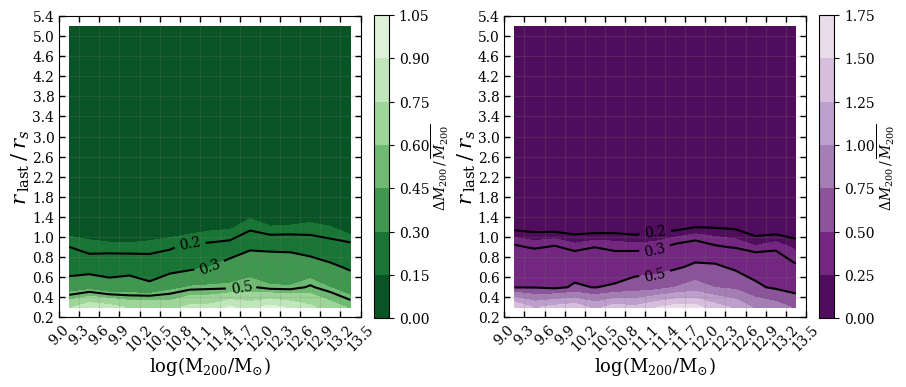

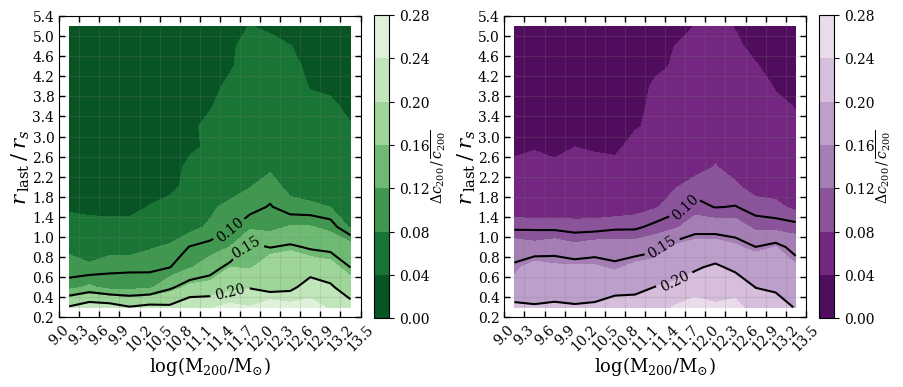

In [1489]:
fig,ax1,ax2 = get_axes(0.35)
axs = [ax1,ax2]
Qs = [Qlm_per_n.copy(),Qlm_per_c.copy()]
cmaps = [pa.gn,pa.pr_r]
lev = [0.20,0.30,0.50]
for i in range(2):
    ax = axs[i]
    Q = Qs[i]
    cn = ax.contourf(LM,RN,Q,cmap = cmaps[i])
    cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
    cb.set_label(label = '$\Delta M_{200}\,/\,\overline{M_{200}}$',labelpad = 0.2)
    cn = ax.contour(LM,RN,Q,levels = lev,colors = 'k')
    cn.clabel()
    ax.set_title('')
# plt.suptitle('M200$')
plt.savefig('../Output/reliability/Bry_M200_percentage_error.pdf',bbox_inches = 'tight',dpi = 300)

fig,ax1,ax2 = get_axes(0.35)
axs = [ax1,ax2]
Qs = [Qc2_per_n.copy(),Qc2_per_c.copy()]
cmaps = [pa.gn,pa.pr_r]
lev = [0.1,0.15,0.2]
for i in range(2):
    ax = axs[i]
    Q = Qs[i]
    cn = ax.contourf(LM,RN,Q,cmap = cmaps[i])
    cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
    cb.set_label(label = '$\Delta c_{200}\,/\,\overline{c_{200}}$',labelpad = 0.2)
    cn = ax.contour(LM,RN,Q,levels = lev, colors = 'k')
    cn.clabel()
    ax.set_title('')
# plt.suptitle('c200$')
plt.savefig('../Output/reliability/Bry_c200_percentage_error.pdf',bbox_inches = 'tight',dpi = 300)

    
# fig,ax1,ax2 = get_axes(0.3)
# axs = [ax1,ax2]
# Qs = [Qr1_per_n.copy(),Qr1_per_c.copy()]
# cmaps = [pa.gn,pa.pr_r]
# lev = 0.3
# for i in range(2):
#     if i == 0:
#         continue
#     ax = axs[i]
#     Q = Qs[i]
#     cn = ax.contourf(LM,RN,Q,cmap = cmaps[i])
#     cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
#     cn = ax.contour(LM,RN,Q,levels = [lev], colors = 'k')
#     Delsmall(cn)
#     cn.clabel()
#     ax.set_title('')
# ax1.remove()
# # plt.suptitle('rc$')
# plt.savefig('../Output/reliability/Bry_rc_percentage_error.pdf',bbox_inches = 'tight',dpi = 300)

    
# fig,ax1,ax2 = get_axes(0.3)
# axs = [ax1,ax2]
# Qs = [Qyd_per_n.copy(),Qyd_per_c.copy()]
# cmaps = [pa.gn,pa.pr_r]
# lev = 0.2
# for i in range(2):
#     ax = axs[i]
#     Q = Qs[i]
#     cn = ax.contourf(LM,RN,Q,cmap = cmaps[i])
#     cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
#     cn = ax.contour(LM,RN,Q,levels = [lev], colors = 'k')
#     cn.clabel()
#     ax.set_title('')
# # plt.suptitle('yd$')
# plt.savefig('../Output/reliability/Bry_yd_percentage_error.pdf',bbox_inches = 'tight',dpi = 300)


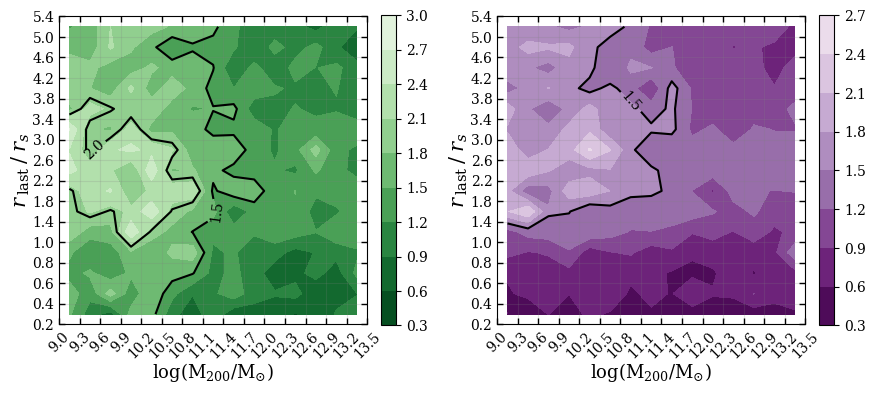

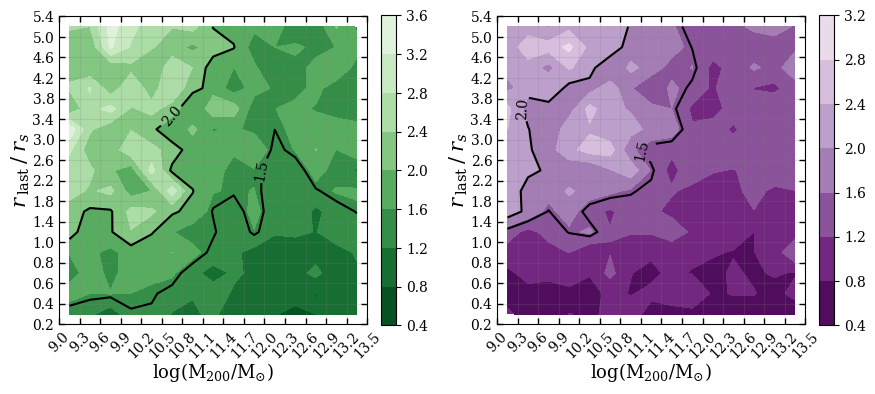

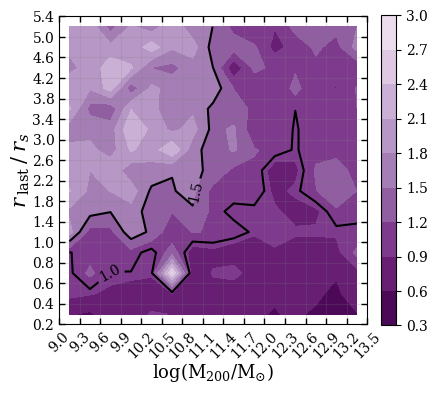

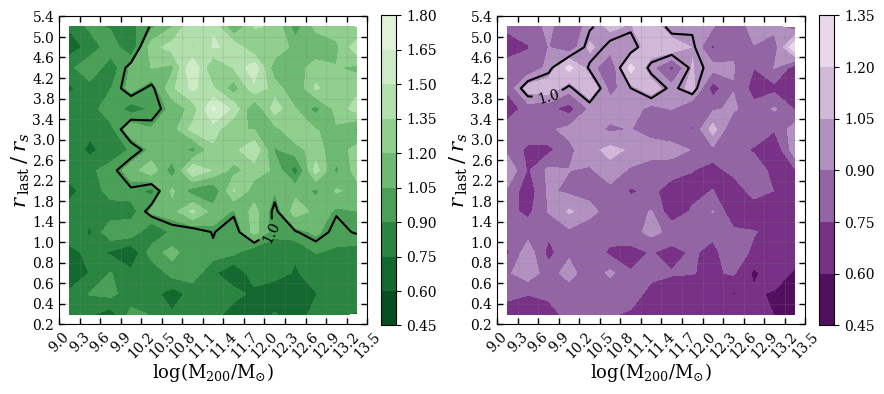

In [1475]:
fig,ax1,ax2 = get_axes(0.3)
axs = [ax1,ax2]
Qs = [Qlm_del_n.copy(),Qlm_del_c.copy()]
cmaps = [pa.gn,pa.pr_r]
lev = [1.5,2.]
for i in range(2):
    ax = axs[i]
    Q = Qs[i]
    cn = ax.contourf(LM,RN,Q,cmap = cmaps[i])
    cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
    cn = ax.contour(LM,RN,Q,levels = lev,colors = 'k')
    Delsmall(cn)
    cn.clabel()
    ax.set_title('')
# plt.suptitle('M200$')
plt.savefig('../Output/reliability/Bry_M200_no_of_sigmas.pdf',bbox_inches = 'tight',dpi = 300)

fig,ax1,ax2 = get_axes(0.3)
axs = [ax1,ax2]
Qs = [Qc2_del_n.copy(),Qc2_del_c.copy()]
cmaps = [pa.gn,pa.pr_r]
lev = [1.5,2]
for i in range(2):
    ax = axs[i]
    Q = Qs[i]
    cn = ax.contourf(LM,RN,Q,cmap = cmaps[i])
    cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
    cn = ax.contour(LM,RN,Q,levels = lev, colors = 'k')
    Delsmall(cn,5)
    cn.clabel()
    ax.set_title('')
# plt.suptitle('c200$')
plt.savefig('../Output/reliability/Bry_c200_no_of_sigmas.pdf',bbox_inches = 'tight',dpi = 300)

    
fig,ax1,ax2 = get_axes(0.3)
axs = [ax1,ax2]
Qs = [Qr1_del_n.copy(),Qr1_del_c.copy()]
cmaps = [pa.gn,pa.pr_r]
lev = [1,1.5]
for i in range(2):
    if i == 0:
        continue
    ax = axs[i]
    Q = Qs[i]
    cn = ax.contourf(LM,RN,Q,cmap = cmaps[i])
    cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
    cn = ax.contour(LM,RN,Q,levels = lev, colors = 'k')
    Delsmall(cn)
    cn.clabel()
    ax.set_title('')
ax1.remove()
# plt.suptitle('rc$')
plt.savefig('../Output/reliability/Bry_rc_no_of_sigmas.pdf',bbox_inches = 'tight',dpi = 300)

    
fig,ax1,ax2 = get_axes(0.3)
axs = [ax1,ax2]
Qs = [Qyd_del_n.copy(),Qyd_del_c.copy()]
cmaps = [pa.gn,pa.pr_r]
lev = [1,1.5]
for i in range(2):
    ax = axs[i]
    Q = Qs[i]
    cn = ax.contourf(LM,RN,Q,cmap = cmaps[i])
    cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
    cn = ax.contour(LM,RN,Q,levels = lev, colors = 'k')
    Delsmall(cn)
    cn.clabel()
    ax.set_title('')
# plt.suptitle('yd$')
plt.savefig('../Output/reliability/Bry_yd_no_of_sigmas.pdf',bbox_inches = 'tight',dpi = 300)


In [1321]:
def relb(key,oqt,qt,eqt,dqt,per_cutoff = 0.2, dqt_cutoff = 3):
    if isinstance(dqt_cutoff, str):
        if np.abs(oqt-qt)/oqt < per_cutoff:
            ri = 1
        else:
            ri = 0
        return ri
    if key == 'r1':
        dqt_cutoff = dqt_cutoff
        per_cutoff = 0.5
    if eqt/oqt < per_cutoff and dqt < dqt_cutoff:
        ri = 1
    else: 
        ri = 0
    return ri

def Relb(Gdict,Ngals,keys,p_c,d_c):
    if isinstance(Gdict, list):
        len_g = len(Gdict)
    else:
        Gdict = [Gdict]
        len_g = 1
        
    if isinstance(p_c, (int,float)):
        temp = p_c
        p_c= [temp for i in range(len(keys))]
    elif isinstance(p_c, list):
        if len(p_c) != len(keys):
            print ('len of p_d not equal to keys')
            return None
        
    if isinstance(Ngals, list):
        Ngalslist = Ngals
        Ngals = len(Ngals)
    elif isinstance(Ngals, int):
        Ngalslist = False
        
    Rn,Rc = np.zeros([15,15,Ngals*len_g]),np.zeros([15,15,Ngals*len_g])
    for model in ['N','S']:
        fit = 'cusp_fit' if model == 'N' else 'core_fit'
        for lm_i in range(15):
            for rn_i in range(15):
                for l in range(len_g):
                    for i in range(Ngals):
                        if Ngalslist:
                            gali = Ngalslist[i]
                        else:
                            gali = i
                        gal = '%i_%i_%s_gal_%i'%(lm_i,rn_i,model,gali)
                        if len_g > 1:
                            i = Ngals*l + i
                        gdict = Gdict[l]
                        gald = gdict[gal][fit]
                        r_i = 0
                        for j in range(len(keys)):
                            key = keys[j]
                            if key == 'r1' and model == 'N':
                                oqt = 1e-5
                                qt,eqt = 1e-5,0
                                dqt = 0
                            else:
                                qt,eqt = gald[key]
                                oqt = gdict[gal]['original'][key]
                                if key == 'lm':
                                    qt,eqt = logerr(qt,eqt)
                                    oqt = 10**oqt
                                dqt = np.abs(qt - oqt)/eqt
                            r_i += relb(key,oqt,qt,eqt,dqt,per_cutoff = p_c[j],dqt_cutoff = d_c)
                        ri = 1 if r_i == len(keys) else 0
                        if model == 'N':
                            Rn[lm_i,rn_i,i] = ri
                        elif model == 'S':
                            Rc[lm_i,rn_i,i] = ri
    return np.sum(Rn,axis = 2)/float(len_g*Ngals),np.sum(Rc,axis = 2)/float(len_g*Ngals)

In [1418]:
p_c = [0.5,0.2,0.3]
d_c = 2
Gdict = [bry]
Ngals = 50
key1 = ['lm','c2']
key2 = ['lm','c2','r1']
R_per_lmc2_n,R_per_lmc2_c = Relb(Gdict,Ngals,key1,p_c[:len(key1)],1000)
R_per_lmc2rc_n,R_per_lmc2rc_c = Relb(Gdict,Ngals,key2,p_c[:len(key2)],1000)

R_del_lmc2_n,R_del_lmc2_c = Relb(Gdict,Ngals,key1,1000,d_c)
R_del_lmc2rc_n,R_del_lmc2rc_c = Relb(Gdict,Ngals,key2,1000,d_c)

R_lmc2_n,R_lmc2_c = Relb(Gdict,Ngals,key1,p_c[:len(key1)],d_c)
R_lmc2rc_n,R_lmc2rc_c = Relb(Gdict,Ngals,key2,p_c[:len(key2)],d_c)

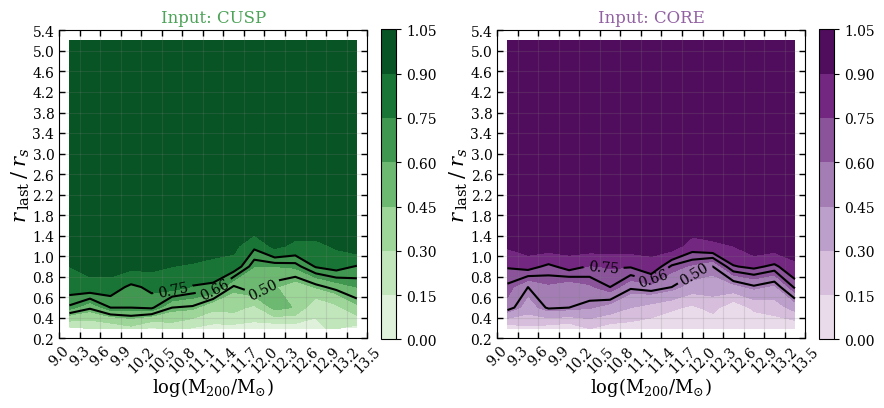

In [1373]:
fig,ax1,ax2 = get_axes(0.3)
axs = [ax1,ax2]
R1 = [R_per_lmc2_n.copy(),R_per_lmc2_c.copy()]
R2 = [R_per_lmc2rc_n.copy(),R_per_lmc2rc_c.copy()]
cmaps = [pa.gn_r,pa.pr]
lev = [0.5,0.66,0.75]
manuals = [[(5,12),(7,12),(10,13)], [(5,10),(7,11.5),(9.5,12)]]
for i in range(2):
    ax = axs[i]
    cn = ax.contourf(LM,RN,R1[i],cmap = cmaps[i])
    cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
    cn = ax.contour(LM,RN,R1[i],colors = 'k',levels = lev)
    cn = Delsmall(cn,0)
    clabels = ax2.clabel(cn, inline = True, colors = 'k', fontsize = 10,
                         manual = manuals[i])

    # if i == 1:
    #     cn = ax.contour(LM,RN,R2[i],colors = 'k',levels = [lev[-1]],linestyles = ['--'])
    #     cn = Delsmall(cn,0)
        # cn = ax.contourf(LM,RN,R2[i],levels = [lev,1],hatches = ['/'],colors = ['none'])
        # cn = Delsmall(cn,0)

plt.savefig('../Output/reliability/Bry_per_1.pdf',bbox_inches = 'tight',dpi = 300)

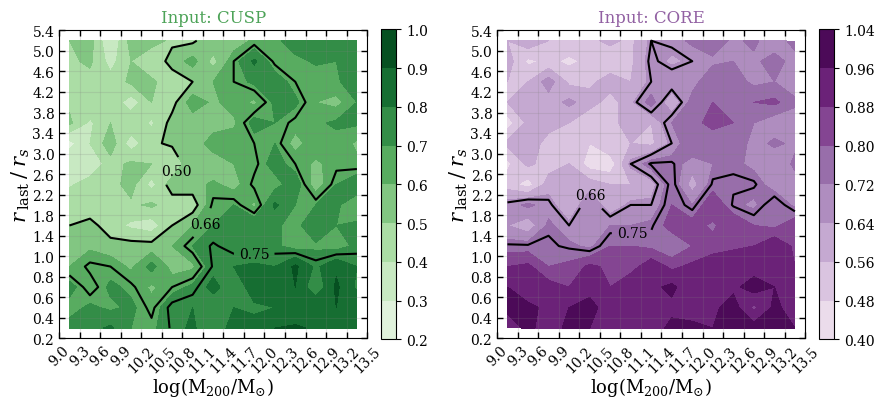

In [1411]:
fig,ax1,ax2 = get_axes(0.3)
axs = [ax1,ax2]
R1 = [R_del_lmc2_n.copy(),R_del_lmc2_c.copy()]
R2 = [R_del_lmc2rc_n.copy(),R_del_lmc2rc_c.copy()]
cmaps = [pa.gn_r,pa.pr]
lev = [0.5,0.66,0.75]
manuals = [[(5.5,6.5),(7,9),(9,11)],[(5,7),(6,9)]]
for i in range(2):
    ax = axs[i]
    cn = ax.contourf(LM,RN,R1[i],cmap = cmaps[i])
    cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
    cn = ax.contour(LM,RN,R1[i],colors = 'k',levels = lev)
    cn = Delsmall(cn,6)
    clabels = ax2.clabel(cn, inline = True, colors = 'k', fontsize = 10,
                         manual = manuals[i])
    for cl in clabels:
        cl.set_rotation(0)
    # if i == 1:
    #     cn = ax.contour(LM,RN,R2[i],colors = 'k',levels = lev,linestyles = ['--'])
    #     cn = Delsmall(cn,6)
        # cn = ax.contourf(LM,RN,R2[i],levels = [0.5,1],hatches = ['/'],colors = ['none'])
        # cn = Delsmall(cn,6)

plt.savefig('../Output/reliability/Bry_del_1.pdf',bbox_inches = 'tight',dpi = 300)

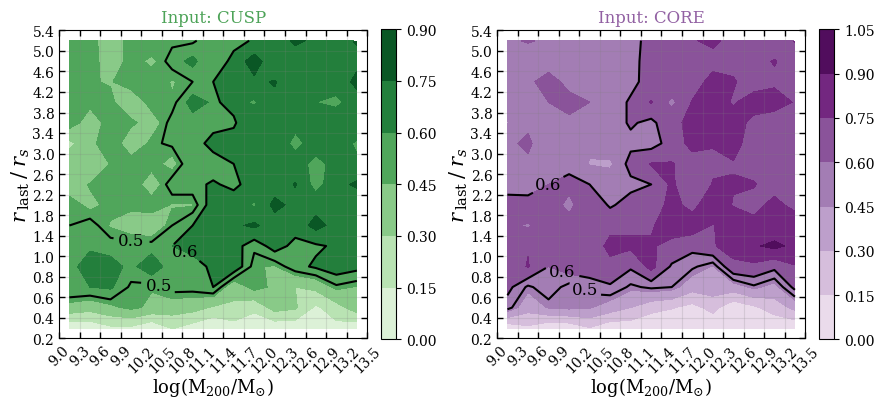

In [1470]:
fig,ax1,ax2 = get_axes(0.3)
axs = [ax1,ax2]
R1 = [R_lmc2_n.copy(),R_lmc2_c.copy()]
R2 = [R_lmc2rc_n.copy(),R_lmc2rc_c.copy()]
lev = [0.5,0.6]
cmaps = [pa.gn_r,pa.pr]
manuals = [[(3,10),(3.8,13),(5,11.2)],[(2.8,8),(2.8,11),(4,12)]]
for i in range(2):
    ax = axs[i]
    cn = ax.contourf(LM,RN,R1[i],cmap = cmaps[i])
    cb = fig.colorbar(cn,ax = ax,fraction = 0.046,pad = 0.04)
    cn = ax.contour(LM,RN,R1[i],colors = 'k',levels = lev)
    cn = Delsmall(cn,6)
    clabels = ax2.clabel(cn, inline = True, colors = 'k', fontsize = 12,
                         manual = manuals[i])
    for cl in clabels:
        cl.set_rotation(0)
    # if i == 1:
    #     cn = ax.contour(LM,RN,R2[i],colors = 'k',levels = [lev],linestyles = ['--'])
    #     cn = Delsmall(cn,6)
    #     cn = ax.contourf(LM,RN,R2[i],levels = [lev,1],hatches = ['/'],colors = ['none'])
    #     cn = Delsmall(cn,6)

plt.savefig('../Output/reliability/Bry_Relb_2.pdf',bbox_inches = 'tight',dpi = 300)

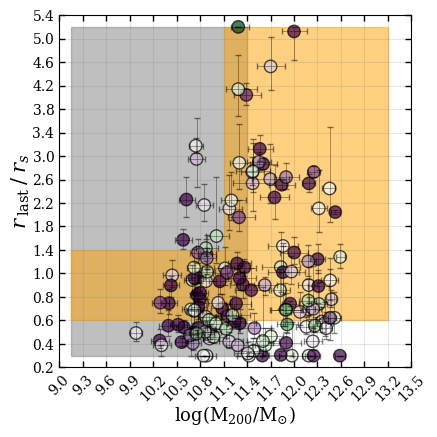

In [1473]:
fig,ax,ax2 = get_axes(0.2)
ax2.remove()
orange = (1.,.64,0)
ax.set_title('')

ax.fill_between([0,7.5],[14,14],[0,0],color = 'grey',alpha = 0.5)
ax.fill_between([0,6.5],[12.5,12.5],[9.5,9.5],color = orange,alpha = 0.5)
ax.fill_between([6.5,13.5],[12.5,12.5],[0,0],color = orange,alpha = 0.5)
# ax.fill_between([0,9.5],[12.5,12.5],[0,0],color = orange,alpha = 0.3)
ax.errorbar(lsi_sparc,rni_sparc,xerr = lsi_err, yerr = rni_err, fmt = '.', ecolor = 'k',
             capsize = 2,elinewidth = 0.5, alpha = 0.5,color = 'none')
sc = ax.scatter(lsi_sparc,rni_sparc,cmap = pa.prgn_r, c = lbf_sparc, marker = 'o',
            s = 80,vmin = -5, vmax = 5, edgecolor = 'k',alpha = 0.7)

plt.savefig('../Output/reliability/Reliable_region.pdf',bbox_inches = 'tight',dpi = 300)